In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [39]:
data1 = pd.read_csv('C:/Users/ssb70/OneDrive/바탕 화면/캡스톤깃헙/data/삼성전자주가(19-27).csv' , encoding = 'cp949')
data2 = pd.read_csv('C:/Users/ssb70/OneDrive/바탕 화면/캡스톤깃헙/data/삼성전자주가(28-29).csv' , encoding = 'cp949')

In [40]:
data = pd.concat([data1 , data2] , axis = 0)

In [41]:
data = data[data['Volume'] != 0]

In [42]:
data.reset_index(drop = True , inplace = True)

In [43]:
data

,Datetime,Open,High,Low,Close,Adj Close,Volume
0,2024-03-19 09:01:00+09:00,72300.0,72300.0,72000.0,72100.0,72100.0,490407
1,2024-03-19 09:02:00+09:00,72100.0,72100.0,71800.0,71900.0,71900.0,619211
2,2024-03-19 09:03:00+09:00,71900.0,71900.0,71800.0,71800.0,71800.0,136585
3,2024-03-19 09:04:00+09:00,71900.0,72000.0,71800.0,72000.0,72000.0,180283
4,2024-03-19 09:05:00+09:00,72000.0,72000.0,71900.0,72000.0,72000.0,61085
...,...,...,...,...,...,...,...
3222,2024-03-29 14:55:00+09:00,82300.0,82400.0,82300.0,82300.0,82300.0,36250
3223,2024-03-29 14:56:00+09:00,82400.0,82400.0,82300.0,82300.0,82300.0,22326
3224,2024-03-29 14:57:00+09:00,82400.0,82400.0,82300.0,82400.0,82400.0,390999
3225,2024-03-29 14:58:00+09:00,82400.0,82400.0,82300.0,82400.0,82400.0,260646


In [44]:
data["Datetime"] = pd.to_datetime(data["Datetime"]).dt.strftime('%Y-%m-%d %H:%M:%S')
data['Datetime'] = pd.to_datetime(data['Datetime'])
data.set_index('Datetime', inplace=True)

In [45]:
# 필요한 라이브러리 임포트
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# 데이터 로드 및 선택
features = data[['Open', 'High', 'Low', 'Close', 'Volume']].values

# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# 시퀀스 데이터 생성 함수
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length, 3]  # 종가(Close)를 예측값으로 설정
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# 시퀀스 데이터 생성
seq_len = 30  # 시퀀스 길이 설정
X, y = create_sequences(scaled_features, seq_len)
y = y.reshape(-1, 1)  # 모델의 출력 형태에 맞게 y를 조정

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42 , shuffle = False)

# 기존 훈련 데이터를 다시 훈련 및 검증 데이터로 분할
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=False)

# Tensor로 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# DataLoader 설정
train_data = TensorDataset(X_train_tensor.to(device), y_train_tensor.to(device))
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=False)

val_data = TensorDataset(X_val_tensor.to(device), y_val_tensor.to(device))
val_loader = DataLoader(dataset=val_data, batch_size=16, shuffle=False)


# Tensor로 변환
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# 모델 설정 변경
# 일단은 통합적으로 생성
class configs:
    seq_len = 30
    pred_len = 1
    enc_in = 5  # 입력 채널을 5로 변경 (시가, 고가, 저가, 종가, 거래량)
    individual = False

In [46]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride,  padding= 0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class Model(nn.Module):
    """
    Decomposition-Linear
    """
    def __init__(self, configs):
        super(Model, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len

        # Decompsition Kernel Size
        kernel_size = 5
        self.decompsition = series_decomp(kernel_size)
        self.individual = configs.individual
        self.channels = configs.enc_in

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList()
            self.Linear_Trend = nn.ModuleList()

            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))

                # Use this two lines if you want to visualize the weights
                # self.Linear_Seasonal[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
                # self.Linear_Trend[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
        else:
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)

            # Use this two lines if you want to visualize the weights
            # self.Linear_Seasonal.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
            # self.Linear_Trend.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))

    def forward(self, x):
        # x: [batch size, seqence length, channel]
        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init, trend_init = seasonal_init.permute(0,2,1), trend_init.permute(0,2,1)
        if self.individual:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),self.pred_len],dtype=trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        return x.permute(0,2,1) # to [Batch, prediction length, channel]

model = Model(configs)

In [49]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

patience = 25  # 검증 손실이 개선되지 않는 에포크 허용 횟수
min_delta = 0.00001  # 개선으로 간주되기 위한 최소 변화량
best_loss = np.inf  # 가장 낮은 검증 손실을 추적
last_val_loss = np.inf
patience_counter = 0  # 개선되지 않는 에포크를 세는 카운터

# 데이터를 DataLoader로 변환
train_data = TensorDataset(torch.FloatTensor(X_train).to(device), torch.FloatTensor(y_train).to(device))
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle= False)

model.to(device)

# 손실 함수와 최적화 알고리즘 설정
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 학습 과정
epochs = 200

train_losses = []
val_losses = []

for epoch in range(epochs):
  model.train()  # 모델을 훈련 모드로 설정
  train_loss = 0.0

  for seqs, labels in train_loader:
      optimizer.zero_grad()  # 그래디언트 초기화
      outputs = model(seqs)  # 모델을 통한 예측
      loss = criterion(outputs[:,:,3], labels)  # 손실 계산
      loss.backward()  # 손실을 통한 그래디언트 계산
      optimizer.step()  # 최적화 알고리즘을 통한 파라미터 업데이트

      train_loss += loss.item() * seqs.size(0)

  train_loss /= len(train_loader.dataset)
  train_losses.append(train_loss)

  model.eval()  # 모델을 평가 모드로 설정
  val_loss = 0.0

  with torch.no_grad():
    for seqs, labels in val_loader:
        seqs = seqs.to(device)
        labels = labels.to(device)

        outputs = model(seqs)
        loss = criterion(outputs[:,:,3], labels)
        val_loss += loss.item() * seqs.size(0)  # 누적 손실 계산

    # 에포크별 평균 검증 손실 계산
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

  print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}')

  if val_loss < best_loss - min_delta:
    best_loss = val_loss
    patience_counter = 0
  else:
    patience_counter += 1
    print(f'Early Stopping Counter {patience_counter} of {patience}')

  last_val_loss = val_loss  # 마지막 검증 손실 업데이트

  if patience_counter >= patience:
    print("Early stopping initiated.")
    print(f"Best Validation Loss: {best_loss:.5f}")
    break

Epoch 1/200, Train Loss: 0.00018, Val Loss: 0.00008
Epoch 2/200, Train Loss: 0.00017, Val Loss: 0.00008
Early Stopping Counter 1 of 25
Epoch 3/200, Train Loss: 0.00017, Val Loss: 0.00007
Early Stopping Counter 2 of 25
Epoch 4/200, Train Loss: 0.00016, Val Loss: 0.00007
Early Stopping Counter 3 of 25
Epoch 5/200, Train Loss: 0.00016, Val Loss: 0.00007
Early Stopping Counter 4 of 25
Epoch 6/200, Train Loss: 0.00016, Val Loss: 0.00007
Early Stopping Counter 5 of 25
Epoch 7/200, Train Loss: 0.00016, Val Loss: 0.00007
Early Stopping Counter 6 of 25
Epoch 8/200, Train Loss: 0.00016, Val Loss: 0.00007
Early Stopping Counter 7 of 25
Epoch 9/200, Train Loss: 0.00016, Val Loss: 0.00007
Early Stopping Counter 8 of 25
Epoch 10/200, Train Loss: 0.00016, Val Loss: 0.00007
Early Stopping Counter 9 of 25
Epoch 11/200, Train Loss: 0.00016, Val Loss: 0.00007
Early Stopping Counter 10 of 25
Epoch 12/200, Train Loss: 0.00016, Val Loss: 0.00007
Early Stopping Counter 11 of 25
Epoch 13/200, Train Loss: 0.00

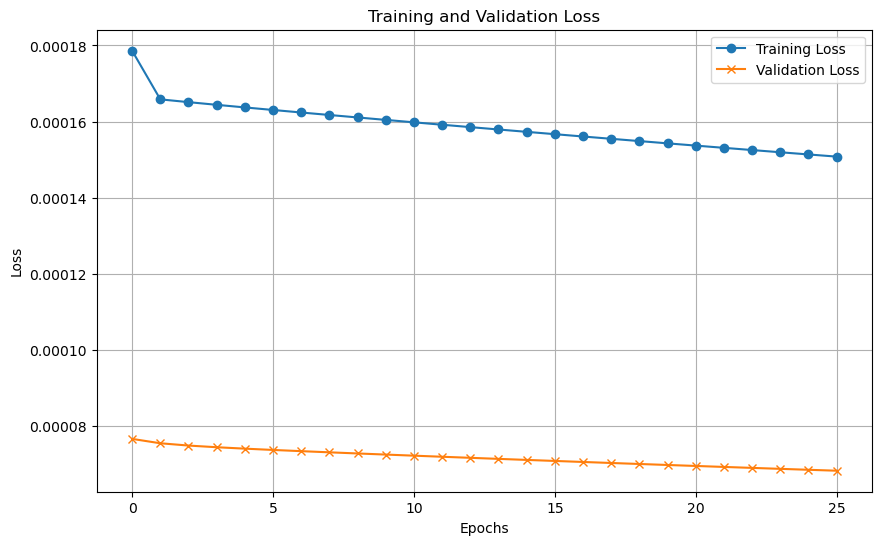

In [50]:
import matplotlib.pyplot as plt

# 위에 제시된 훈련 및 검증 과정 코드 실행 후 실행

# 훈련 손실과 검증 손실을 에포크별로 그래프로 그리기
plt.figure(figsize=(10, 6))  # 그래프 크기 설정
plt.plot(train_losses, label='Training Loss', marker='o')  # 훈련 손실 그래프
plt.plot(val_losses, label='Validation Loss', marker='x')  # 검증 손실 그래프
plt.title('Training and Validation Loss')  # 그래프 제목
plt.xlabel('Epochs')  # x축 라벨
plt.ylabel('Loss')  # y축 라벨
plt.legend()  # 범례 표시
plt.grid(True)  # 그리드 표시
plt.show()  # 그래프 보여주기


In [51]:
# 테스트 데이터셋에 대한 평가 및 결과 출력
model.to(device)

model.eval()  # 모델을 평가 모드로 설정
test_losses = []  # 테스트 손실을 저장할 리스트
predictions = []  # 예측값을 저장할 리스트
actuals = []  # 실제값을 저장할 리스트

with torch.no_grad():  # 기울기 계산을 비활성화
    for seqs, labels in DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=16 , shuffle = False):
        seqs = seqs.to(device)
        labels = labels.to(device)

        outputs = model(seqs)

        # 손실 계산
        loss = criterion(outputs[:,:,3], labels)
        test_losses.append(loss.item())

        # 예측값과 실제값 저장
        predictions.extend(outputs[:,:,3].view(-1).cpu().numpy())
        actuals.extend(labels.view(-1).cpu().numpy())

# 평균 테스트 손실 계산 및 출력
average_test_loss = sum(test_losses) / len(test_losses)
print(f'Average Test Loss: {average_test_loss}')

predictions_temp = np.zeros((len(predictions), 5))  # 5는 특성의 총 개수입니다.
predictions_temp[:, 3] = predictions  # 종가 위치에 예측값 할당

actuals_temp = np.zeros((len(actuals), 5))  # 실제 데이터를 위한 동일한 접근 방식
actuals_temp[:, 3] = actuals  # 종가 위치에 실제값 할당


# 예측값과 실제값 출력 (처음 10개 샘플)
predictions_inverse = scaler.inverse_transform(predictions_temp)[:,3]
actuals_inverse = scaler.inverse_transform(actuals_temp)[:,3]


# 역정규화된 예측값과 실제값 출력 (처음 10개 샘플)
print("Predictions vs. Actuals (First 10 Samples, After Inverse Scaling):")
for i in range(10):
    print(f'Prediction: {predictions_inverse[i]:.4f}, Actual: {actuals_inverse[i]:.4f}')

Average Test Loss: 5.196062193135731e-05
Predictions vs. Actuals (First 10 Samples, After Inverse Scaling):
Prediction: 81981.2713, Actual: 82099.9998
Prediction: 81982.1061, Actual: 82200.0001
Prediction: 82045.8270, Actual: 82200.0001
Prediction: 82059.3113, Actual: 82200.0001
Prediction: 82084.4905, Actual: 82099.9998
Prediction: 82060.9778, Actual: 82099.9998
Prediction: 82076.9087, Actual: 82099.9998
Prediction: 82079.0120, Actual: 82099.9998
Prediction: 82099.1828, Actual: 82000.0000
Prediction: 82082.9656, Actual: 82000.0000


In [52]:
differences = [abs(pred - actual) for pred, actual in zip(predictions_inverse, actuals_inverse)]

In [53]:
print("최대 : " , max(differences) ,"최소 : " , min(differences) ,"평균: " , sum(differences) / len(differences))

최대 :  271.4513659477234 최소 :  0.2570211887359619 평균:  63.53879880160093


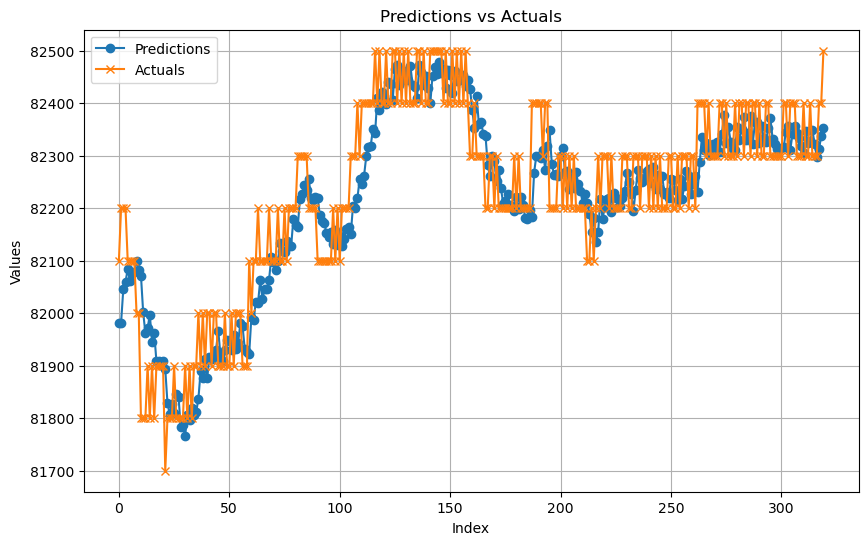

In [55]:
import matplotlib.pyplot as plt

# Plot 생성
plt.figure(figsize=(10, 6))
plt.plot(predictions_inverse, label='Predictions', marker='o')
plt.plot(actuals_inverse, label='Actuals', marker='x')
plt.title('Predictions vs Actuals')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()
